# Data Summary and Goal

## Summary

Tanzania, as a developing country, struggles with providing clean water to its population of over 57,000,000. There are many waterpoints already established in the country, but some are in need of repair while others have failed altogether.

## Goal

Build a classifier to predict the condition of a water well, using information provided in the data. This information includes:
- Date
- Location
- Source
- Funder
- And more!

This data is from the DrivenData.org website. It is part of the "Pump It Up: Data Mining the Water Table" dfetition. DrivenData decided to split the data up into two sets, the "Training Set" and the "Test Set". 

It is implied by the names that we are to use the training set for creating our models, and the test set to test them. For this project, we considered merging the two dataframes in order to have more data to work with, however there are 59,400 entries in the training set and therefore more than enough to make good predicitons. 

If our models are subpar, we may merge the tables to aquire more data points to potentially improve model efficacy.

# Data Cleaning and Feature Engineering

## Import Libraries and Data

In [ ]:
pip install category_encoders

In [1]:
# Import Pandas
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# ignore all future warnings
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

# Load data into  Pandas dataframes
status_groups = pd.read_csv('status_groups.csv')
testset = pd.read_csv('test_set.csv')
df = pd.read_csv('training_set.csv')


# Let's add our target series to the dataframe!
status_groups.drop(['id'], axis=1, inplace=True)
df = pd.concat([df, status_groups], axis=1)

# Analyze shape of dataset
print(f'Shape of dataset: {df.shape}')
display(df.head())


Shape of dataset: (59400, 41)


,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,...,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,...,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,...,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,functional
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,...,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,non functional
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,...,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional


## EDA

In [2]:
df.columns

Index(['id', 'amount_tsh', 'date_recorded', 'funder', 'gps_height',
       'installer', 'longitude', 'latitude', 'wpt_name', 'num_private',
       'basin', 'subvillage', 'region', 'region_code', 'district_code', 'lga',
       'ward', 'population', 'public_meeting', 'recorded_by',
       'scheme_management', 'scheme_name', 'permit', 'construction_year',
       'extraction_type', 'extraction_type_group', 'extraction_type_class',
       'management', 'management_group', 'payment', 'payment_type',
       'water_quality', 'quality_group', 'quantity', 'quantity_group',
       'source', 'source_type', 'source_class', 'waterpoint_type',
       'waterpoint_type_group', 'status_group'],
      dtype='object')

PERMIT ------------------------------------------------------------------------------------------------------------------------

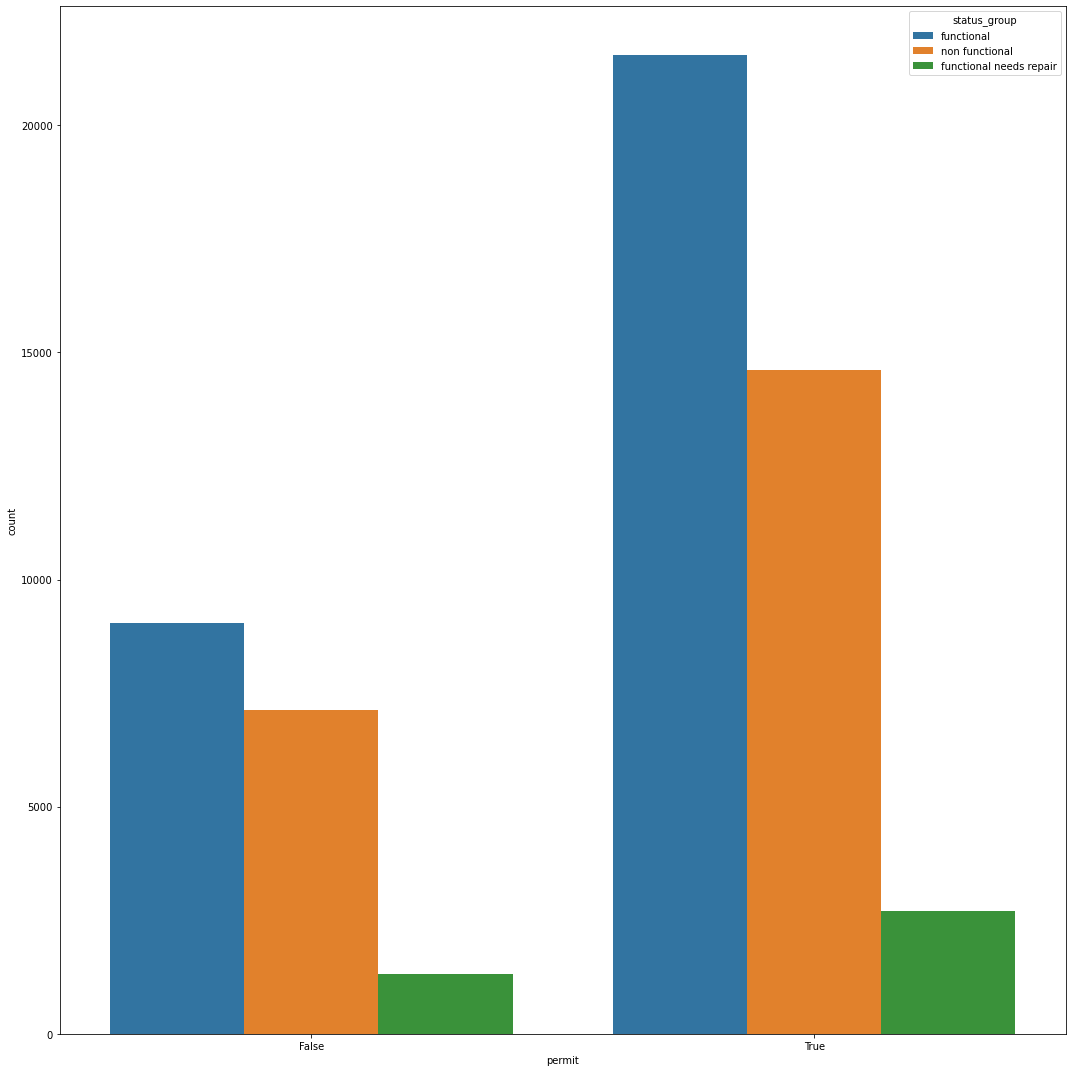

In [3]:
fig, ax = plt.subplots(figsize=(15,15))
sns.countplot(x='permit', hue='status_group', data=df)
plt.tight_layout()

Wells with permits have a larger functional to non-functional ration than those without.

REGION ------------------------------------------------------------------------------------------------------------------------

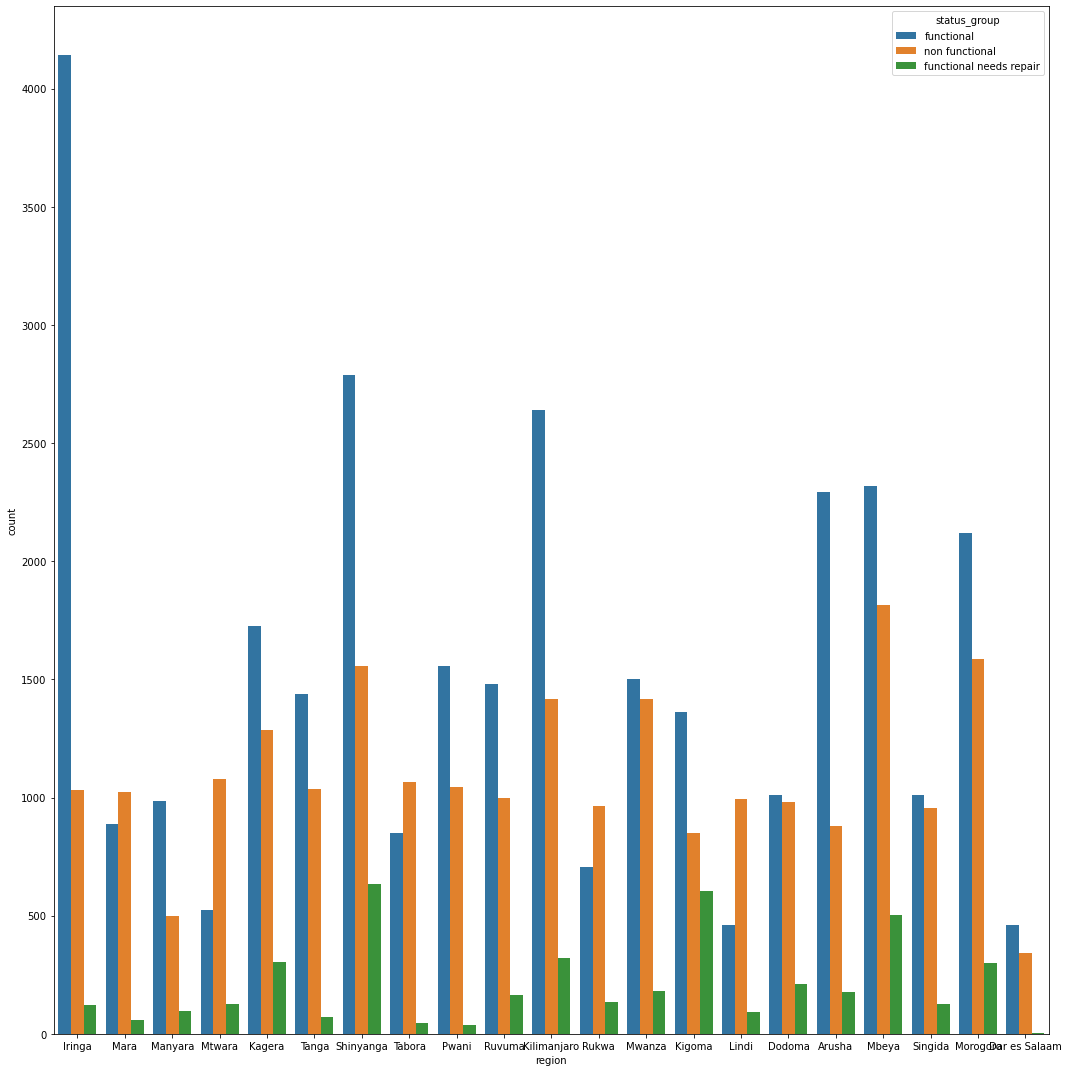

In [4]:
fig, ax = plt.subplots(figsize=(15,15))
sns.countplot(x='region', hue='status_group', data=df)
plt.tight_layout()

Region can be a good indicator of well status, because how many functional vs non-functional wells differ a lot from region to region. For example, if you were to pick a well at random in the region 'Iringa', you would most likely find a functional well, but if you picked a well at random in 'Mtwara', you would most likely find a non-functional well!

BASIN ------------------------------------------------------------------------------------------------------------------------

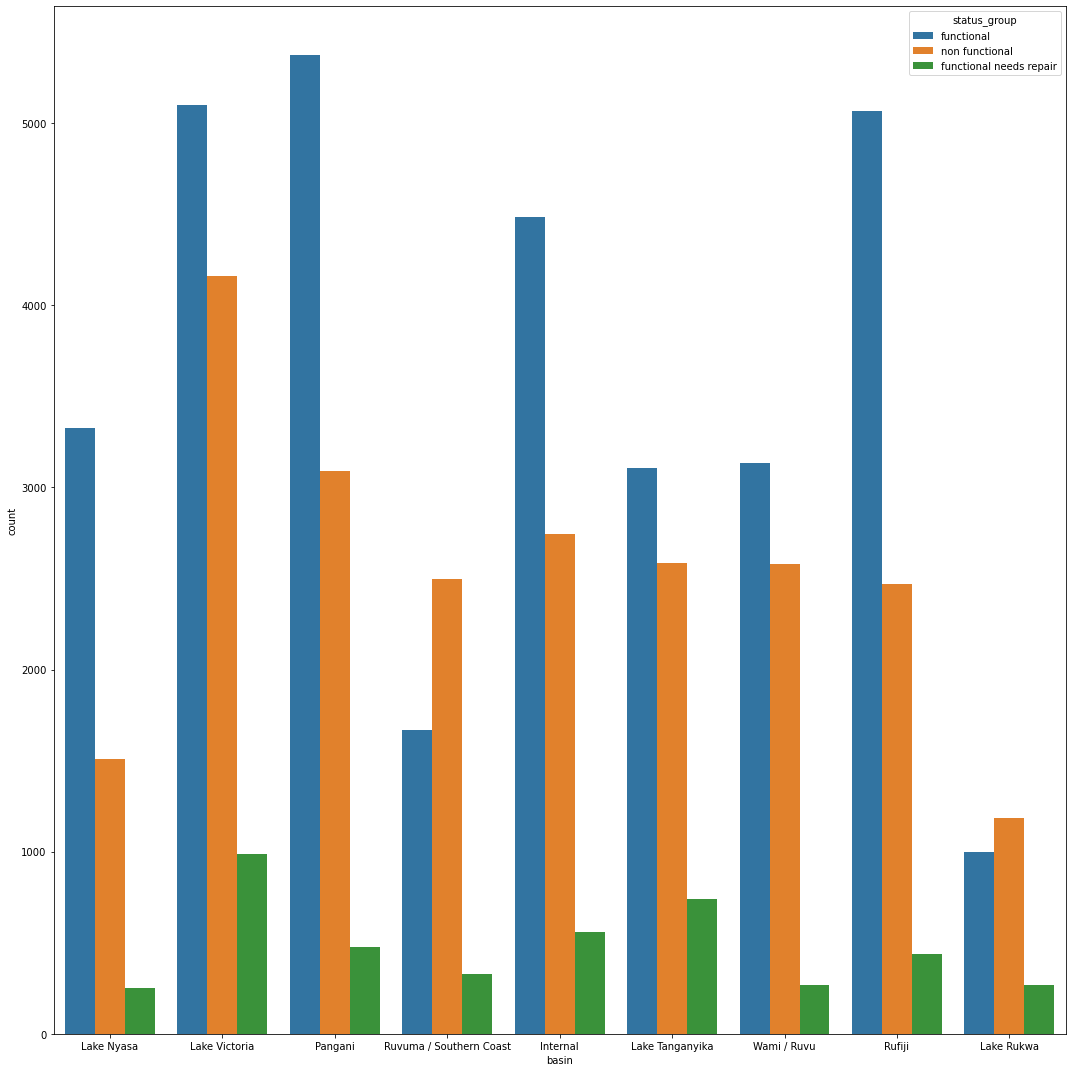

In [5]:
fig, ax = plt.subplots(figsize=(15,15))
sns.countplot(x='basin', hue='status_group', data=df)
plt.tight_layout()

There are some basins that are clearly more successful when establishing wells. Two regions that stick out are 'Ruvuma/Southern Coast' and 'Lake Rukwa', because both of those basins seem to have a majority non-functional wells!

*** Since we are keeping basin, region, and latitude and longitude, we do not need any more columns that provide location data or it would become to noisy. 

CONSTRUCTION YEAR -------------------------------------------------------------------------------------------------------------

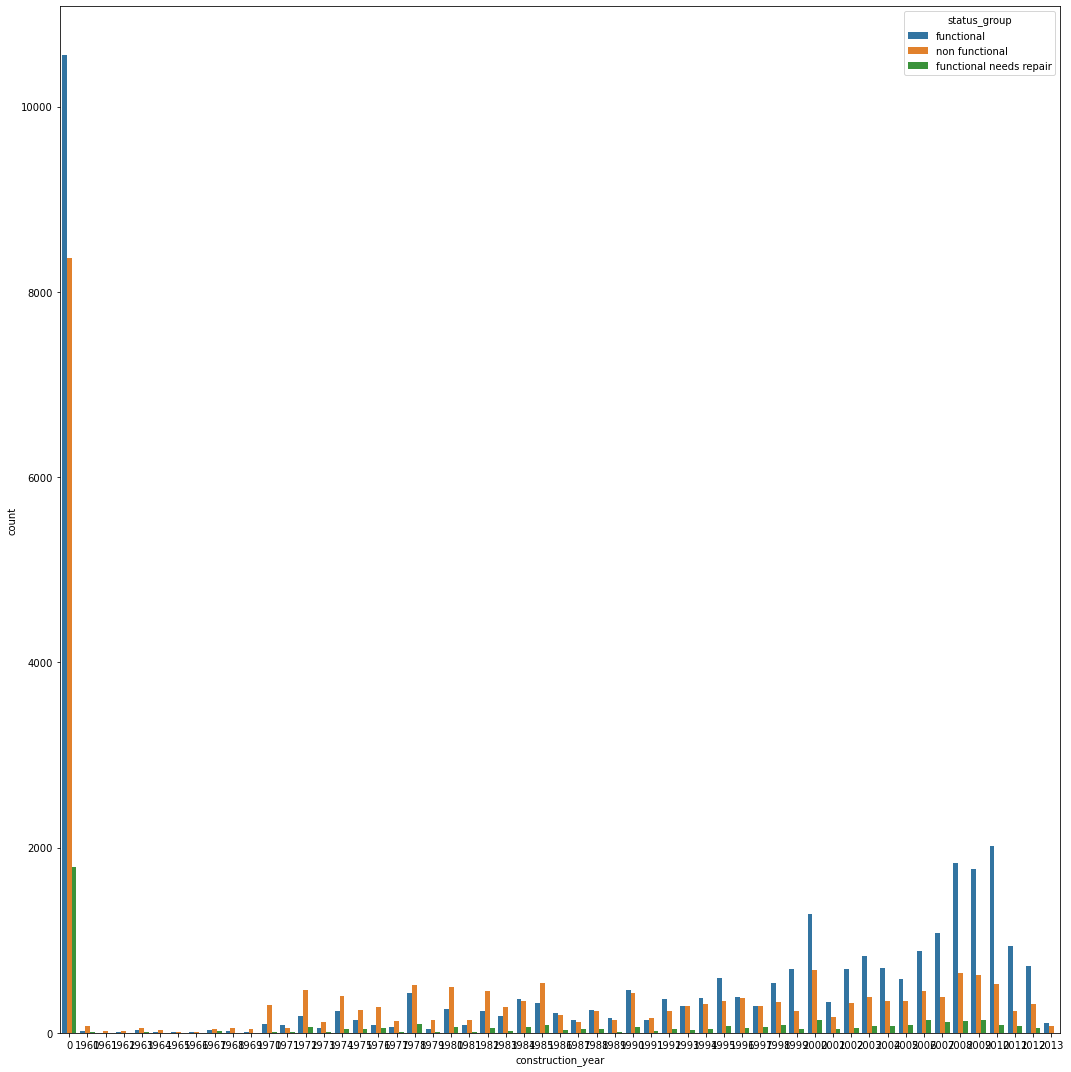

In [6]:
fig, ax = plt.subplots(figsize=(15,15))
sns.countplot(x='construction_year', hue='status_group', data=df)
plt.tight_layout()

When ignoring the data of contruction_year==0, we can clearly see that newer wells are functional more often, while older wells are non-functional more often.

MANAGEMENT ------------------------------------------------------------------------------------------------------------------------

In [ ]:
display(df.management.unique())
display(df.management_group.unique())

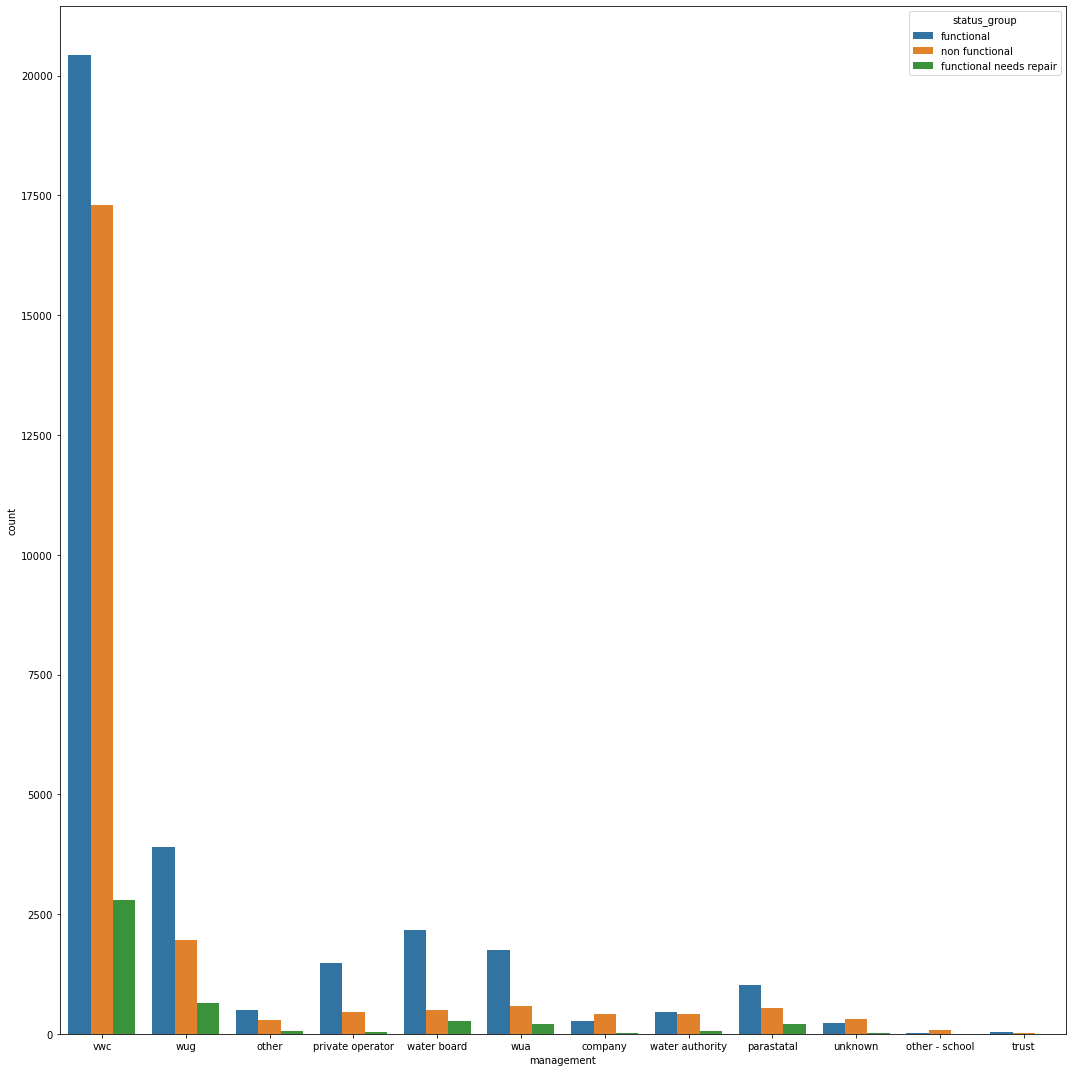

In [7]:
fig, ax = plt.subplots(figsize=(15,15))
sns.countplot(x='management', hue='status_group', data=df)
plt.tight_layout()

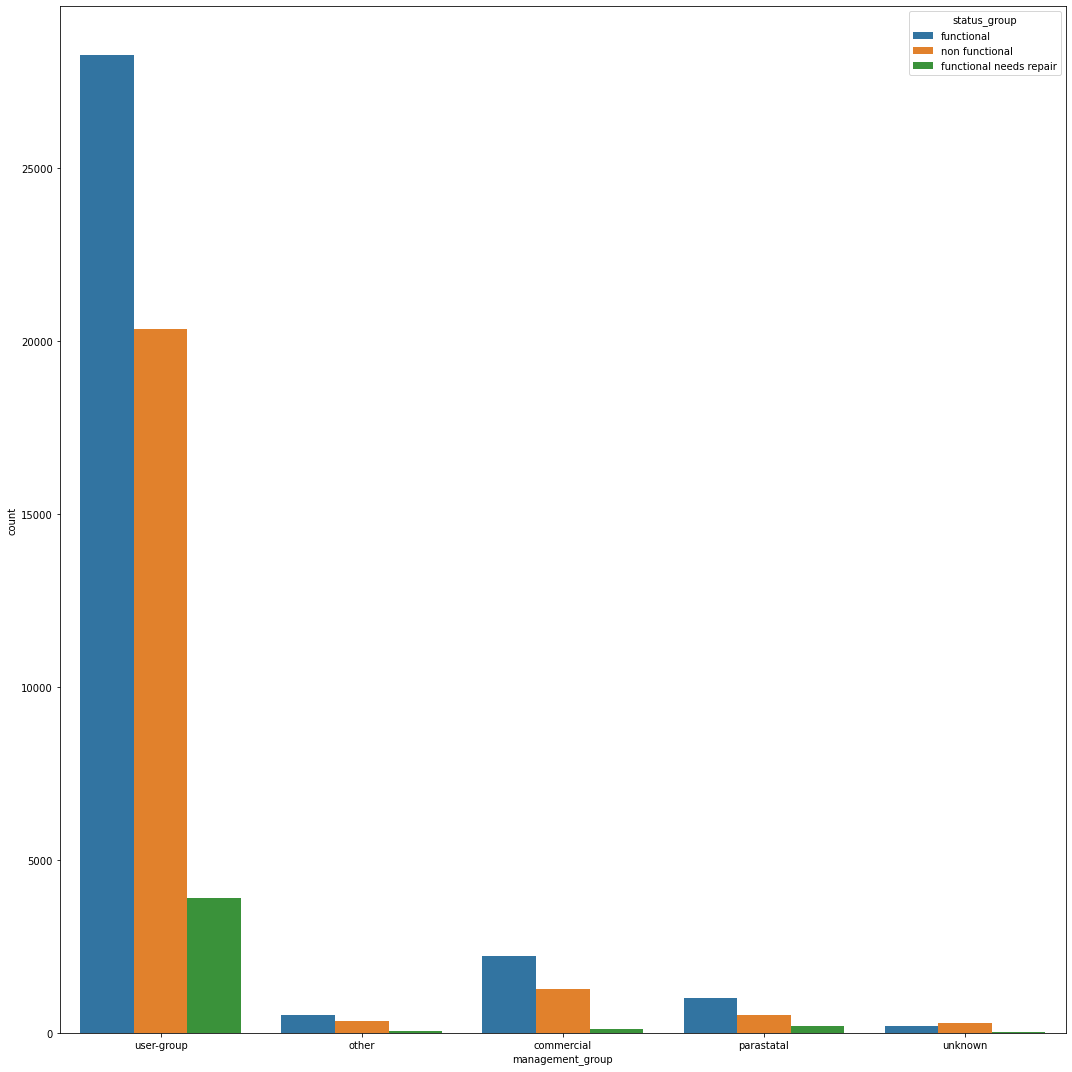

In [8]:
fig, ax = plt.subplots(figsize=(15,15))
sns.countplot(x='management_group', hue='status_group', data=df)
plt.tight_layout()

Both columns provide the same data however 'management' is more detailed, so we will keep that column and drop the other.

PAYMENT ------------------------------------------------------------------------------------------------------------------------

In [ ]:
display(df.payment.unique())
display(df.payment_type.unique())

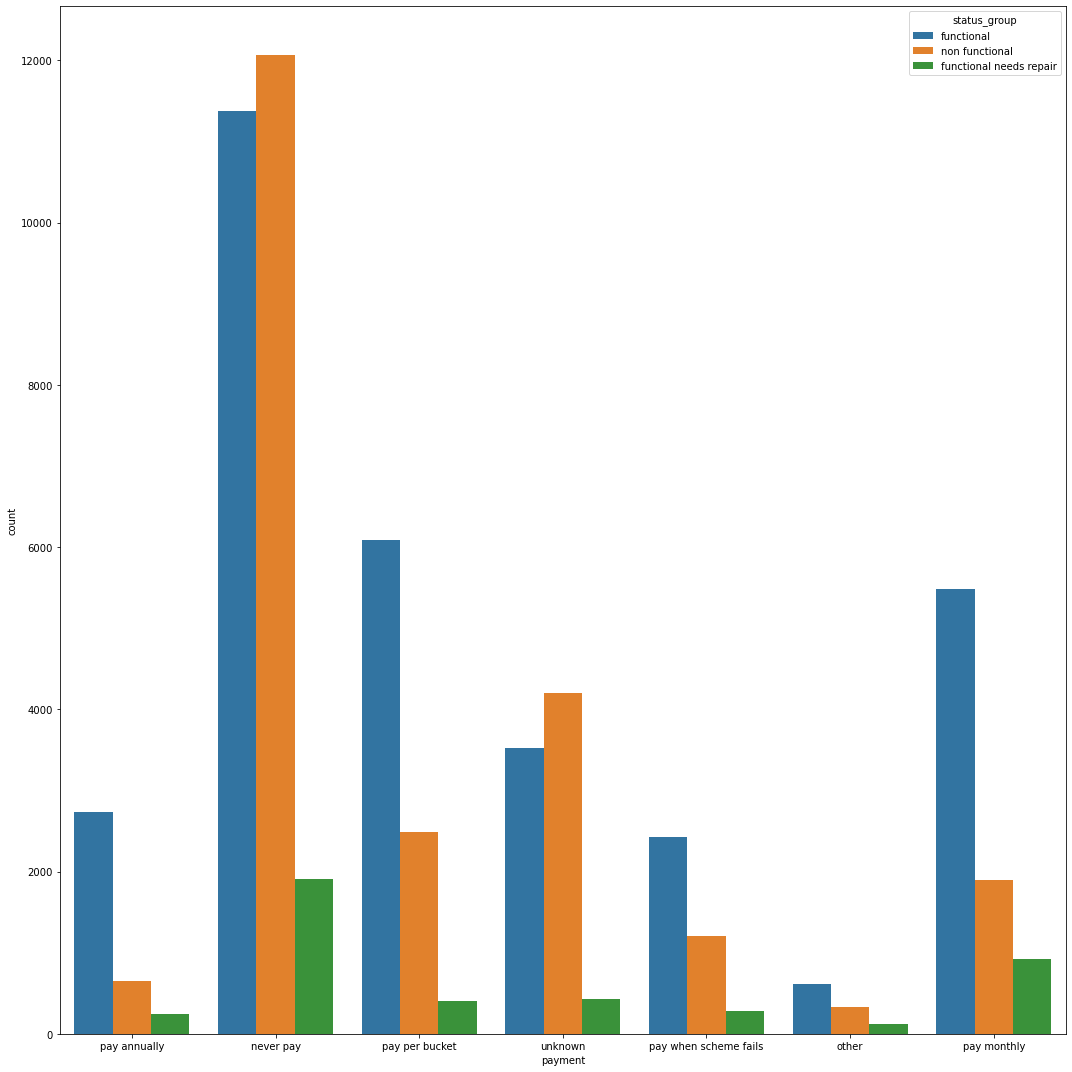

In [9]:
fig, ax = plt.subplots(figsize=(15,15))
sns.countplot(x='payment', hue='status_group', data=df)
plt.tight_layout()

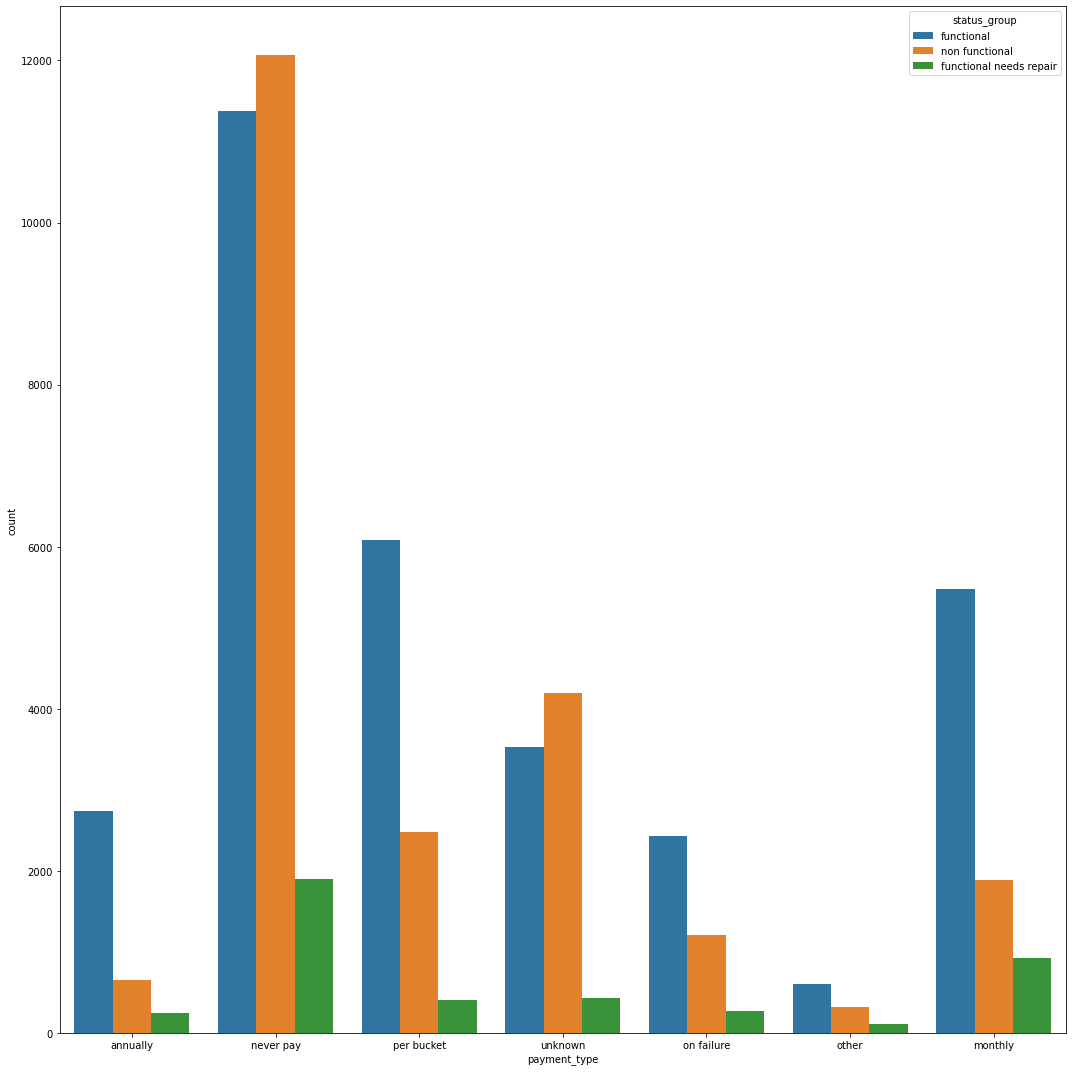

In [10]:
fig, ax = plt.subplots(figsize=(15,15))
sns.countplot(x='payment_type', hue='status_group', data=df)
plt.tight_layout()

'payment' and 'payment_type' are columns with identical data. We can drop one. We will drop 'payment'

QUANTITY ------------------------------------------------------------------------------------------------------------------------

In [ ]:
display(df.quantity.unique())
display(df.quantity_group.unique())

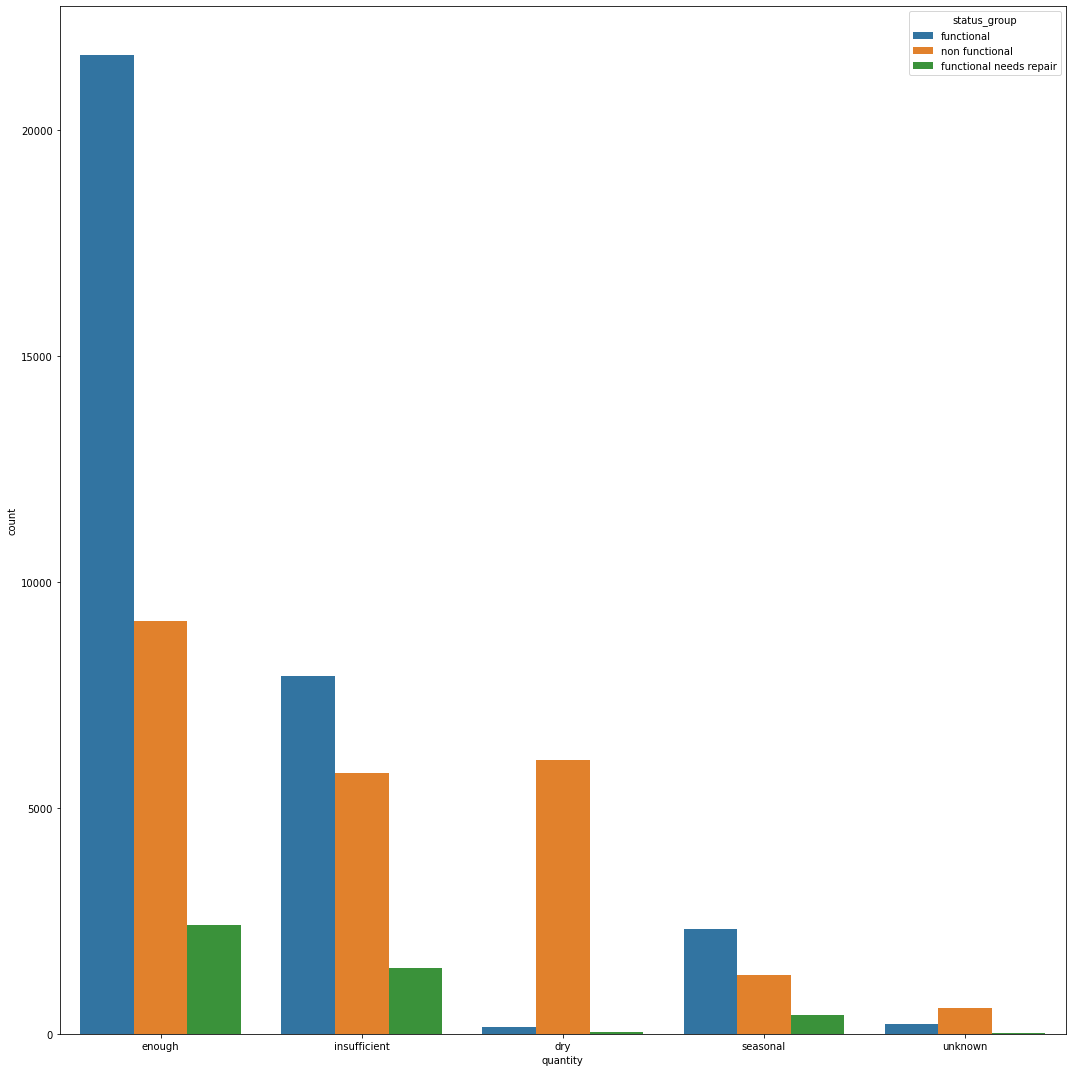

In [11]:
fig, ax = plt.subplots(figsize=(15,15))
sns.countplot(x='quantity', hue='status_group', data=df)
plt.tight_layout()

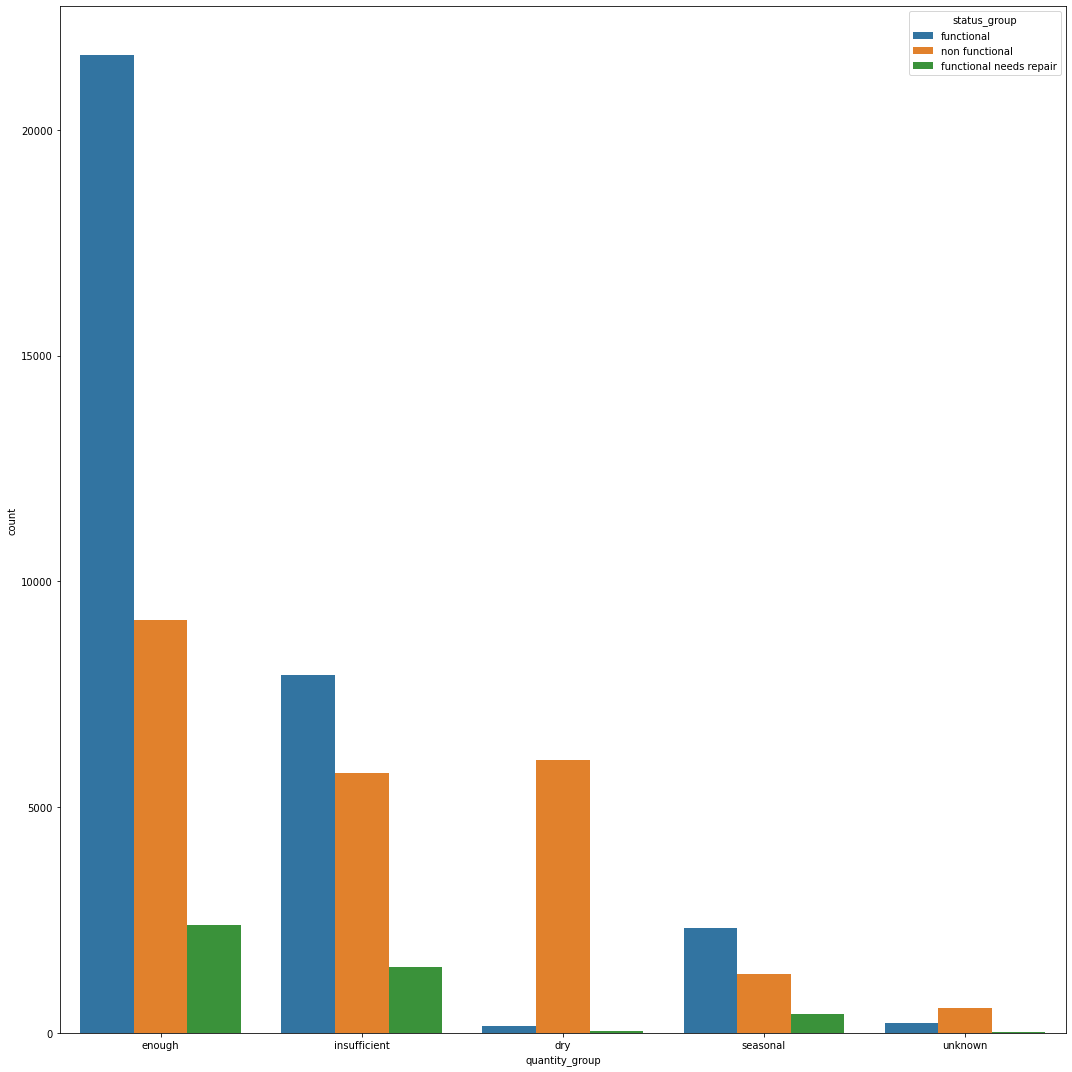

In [12]:
fig, ax = plt.subplots(figsize=(15,15))
sns.countplot(x='quantity_group', hue='status_group', data=df)
plt.tight_layout()

'quantity_group' and 'quantity' are identical columns. We can drop one, and we will drop 'quantity_group' because 'qauntity' is a title that is understood easier.

WATERPOINT TYPE ------------------------------------------------------------------------------------------------------------------------

In [ ]:
display(df.waterpoint_type.unique())
display(df.waterpoint_type_group.unique())

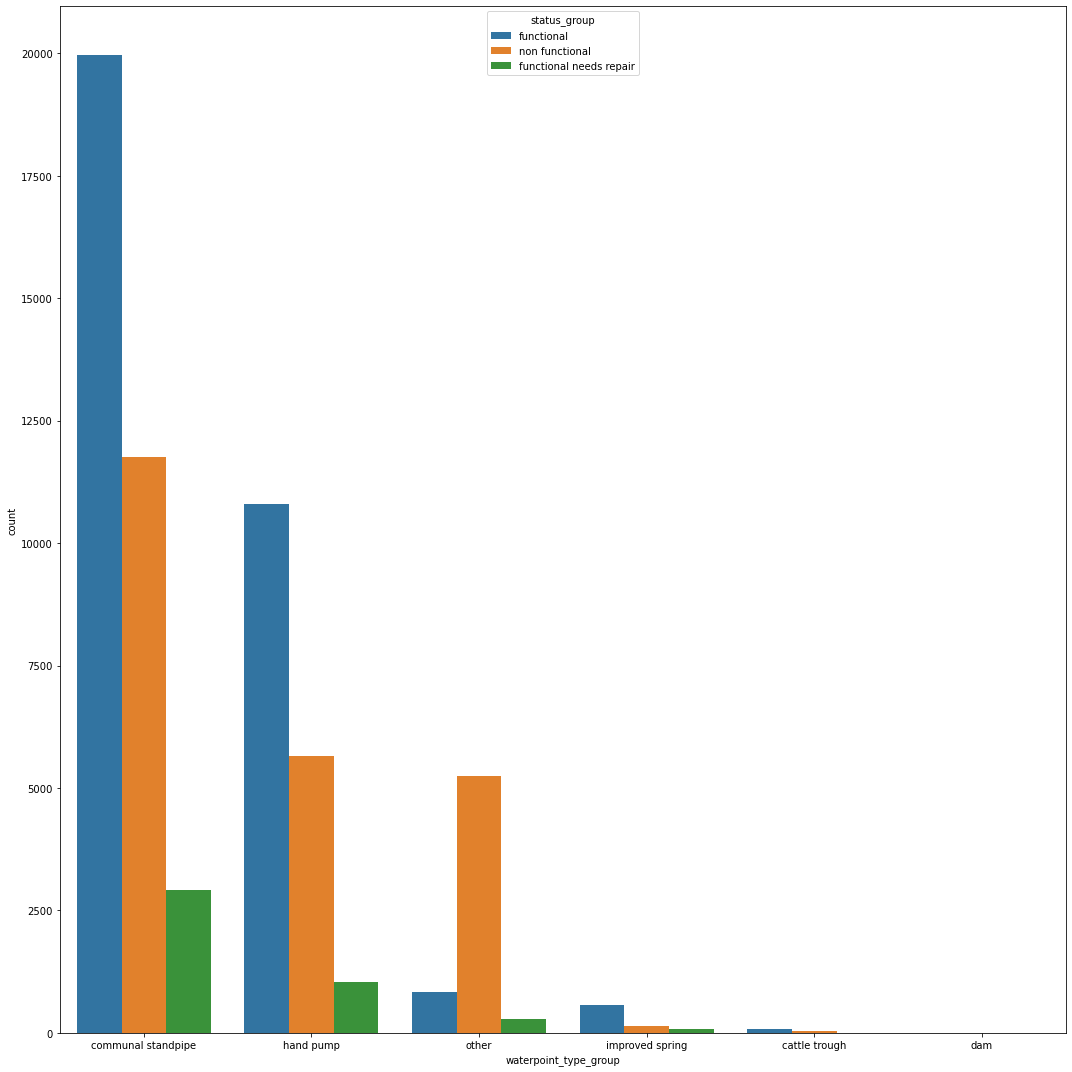

In [13]:
fig, ax = plt.subplots(figsize=(15,15))
sns.countplot(x='waterpoint_type_group', hue='status_group', data=df)
plt.tight_layout()

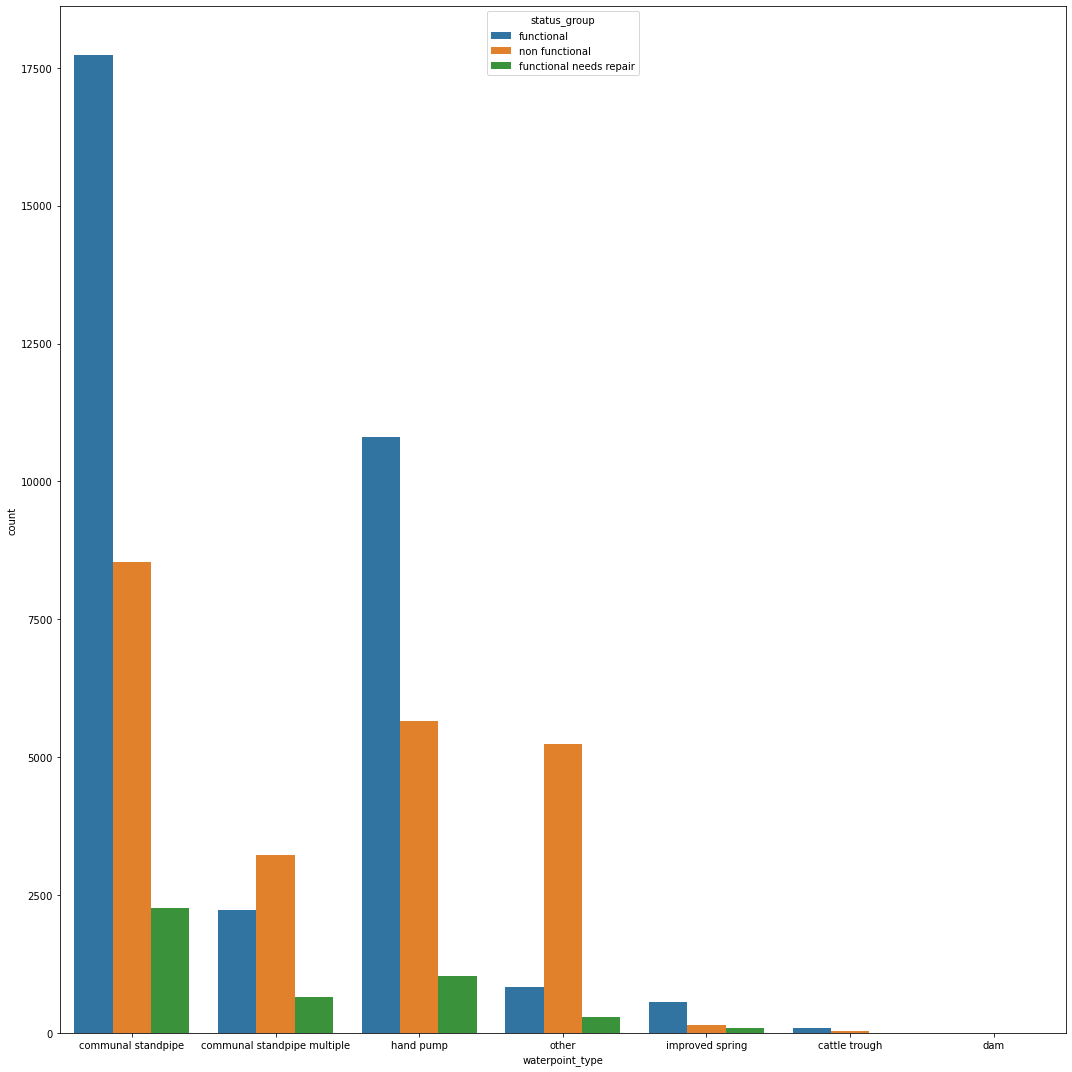

In [14]:
fig, ax = plt.subplots(figsize=(15,15))
sns.countplot(x='waterpoint_type', hue='status_group', data=df)
plt.tight_layout()

The two 'waterpoint_type' columns display redundant information. 'waterpoint_type' is more desireable because there are very noticeable difference between the two groups that 'waterpoint_type_group' joined; 'communal standpoint' and 'communal standpoint multiple'. The majority of wells with a waterpoint type of 'communal standpoint multiple' were non-functional, while the majority of wells with a waterpoint type of 'communal standpoint' were functional. This is an important difference we wish to express.

Overall, handpumps and communal standpoints (and to a lesser extent, improved spring) show a majority occurence of functional wells, while the rest show a majority occurence of non-functional wells

EXTRACTION TYPE ------------------------------------------------------------------------------------------------------------------------

In [ ]:
display(df['extraction_type_class'].unique())
display(df['extraction_type'].unique())
display(df['extraction_type_group'].unique())

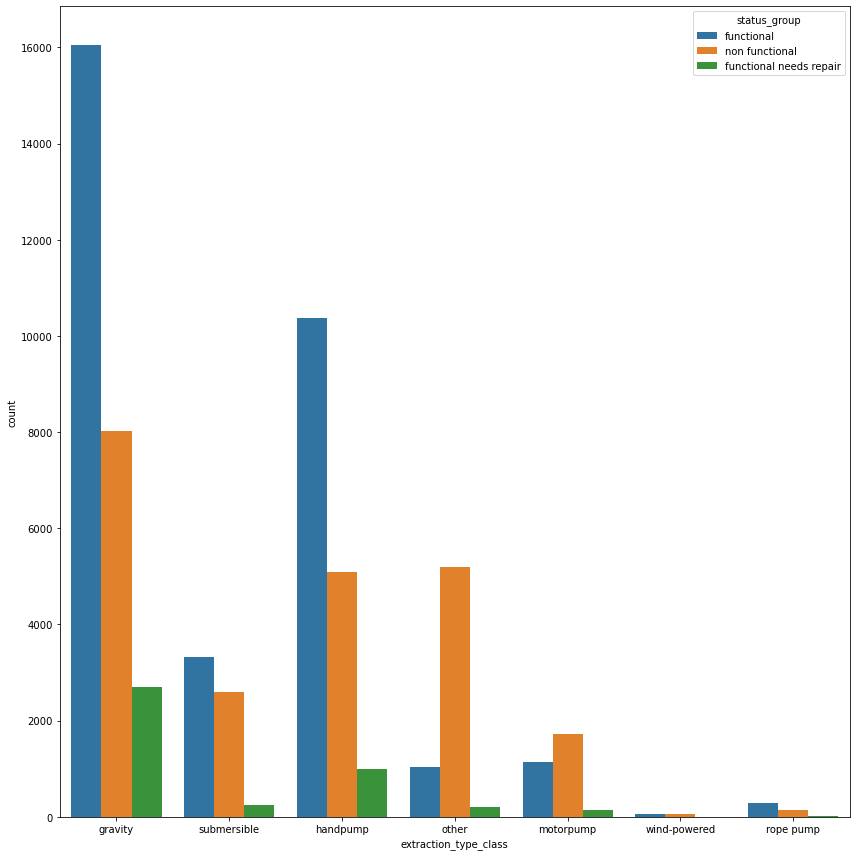

In [15]:
fig, ax = plt.subplots(figsize=(12,12))
sns.countplot(x='extraction_type_class', hue='status_group', data=df)
plt.tight_layout()

The three 'extraction_type' columns display the same information, however both 'extraction_type' and 'extraction_type_group' have many more unique values than 'extraction_type_class'. When looking at the columns, it is clear that 'extraction_type_class' is more interpretable, and reduces the cardinality of this 'extraction_type' data considerably, without reducing its effectiveness in conveying the information it intends to. For this reason, we will be keeping 'extraction_type_class' and dropping the others.

Overall, the data of wells that use a gravity and handpump extraction type have the highest occurence of functional wells, while motorpump and other extraction type are most likely to be non-functional in comparison. Submersible also has a majority functional, however it is not as pronounced as handpump and gravity.

SOURCE  ------------------------------------------------------------------------------------------------------------------------

In [18]:
display(df['source_class'].unique())
display(df['source'].unique())
display(df['source_type'].unique())

array(['groundwater', 'surface', 'unknown'], dtype=object)

array(['spring', 'rainwater harvesting', 'dam', 'machine dbh', 'other',
       'shallow well', 'river', 'hand dtw', 'lake', 'unknown'],
      dtype=object)

array(['spring', 'rainwater harvesting', 'dam', 'borehole', 'other',
       'shallow well', 'river/lake'], dtype=object)

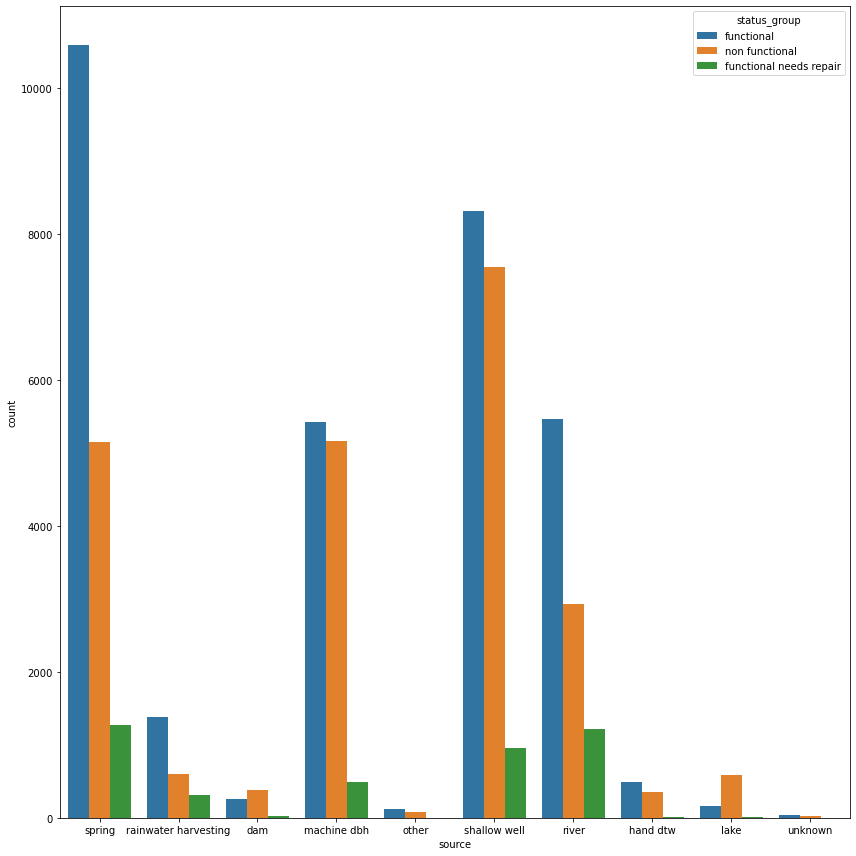

In [16]:
fig, ax = plt.subplots(figsize=(12,12))
sns.countplot(x='source', hue='status_group', data=df)
plt.tight_layout()

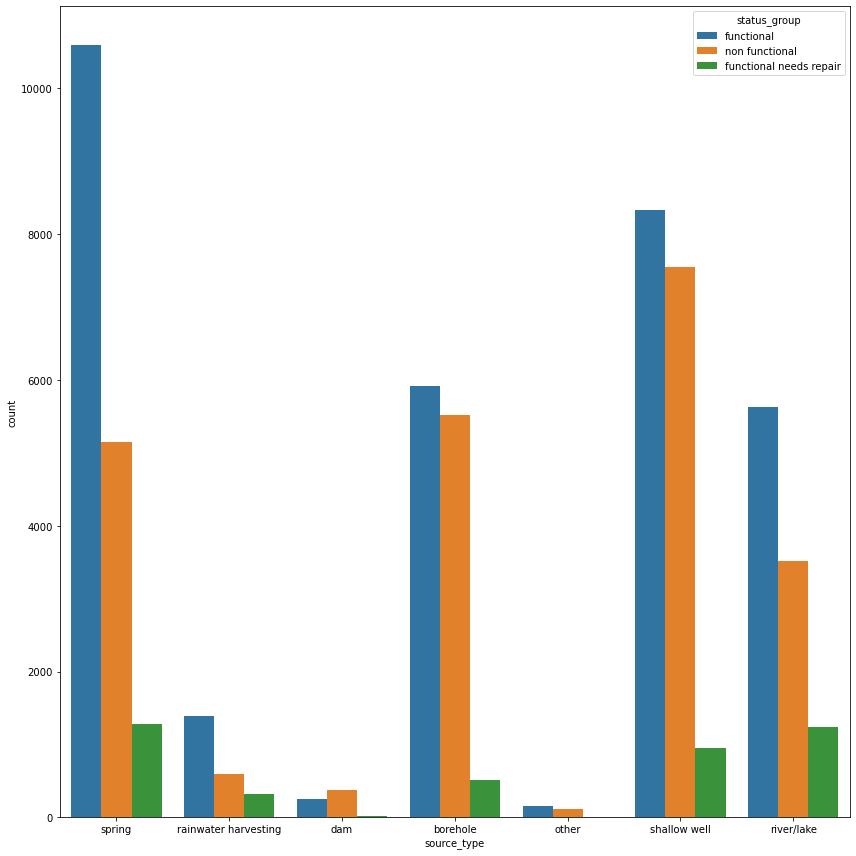

In [17]:
fig, ax = plt.subplots(figsize=(12,12))
sns.countplot(x='source_type', hue='status_group', data=df)
plt.tight_layout()

The three 'source' columns provide the same information, with 'source_class' being the least specific and 'source' being the most specific. 'Source' provides mroe detailed information without severely increasing cardinality, and therefore we will keep that column and drop the others.

Springs, rainwater harvesting, shallow wells, rivers, DBH machines, and hand boreholes (hand dtw) are most likely to be functional in comparison to the other source types. Noticeably, wells with their source as a river are functional significantly more often than if the source is a lake. This information was not conveyed in the 'source_type' column.

QUALITY ------------------------------------------------------------------------------------------------------------------------

In [ ]:
display(df.water_quality.unique())
display(df.quality_group.unique())

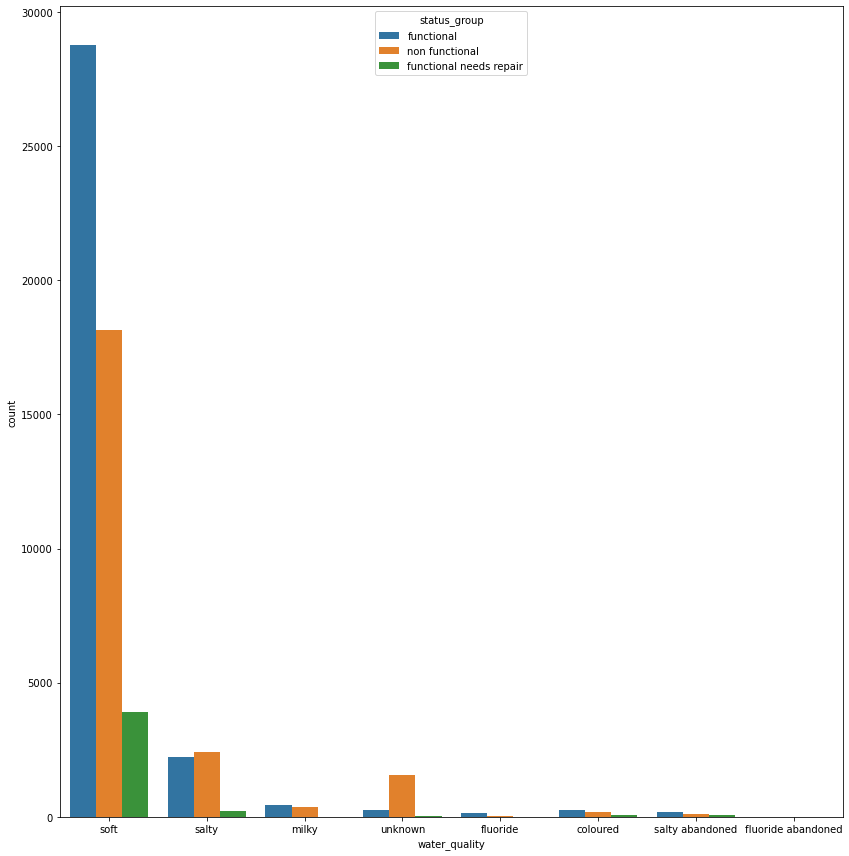

In [19]:
fig, ax = plt.subplots(figsize=(12,12))
sns.countplot(x='water_quality', hue='status_group', data=df)
plt.tight_layout()

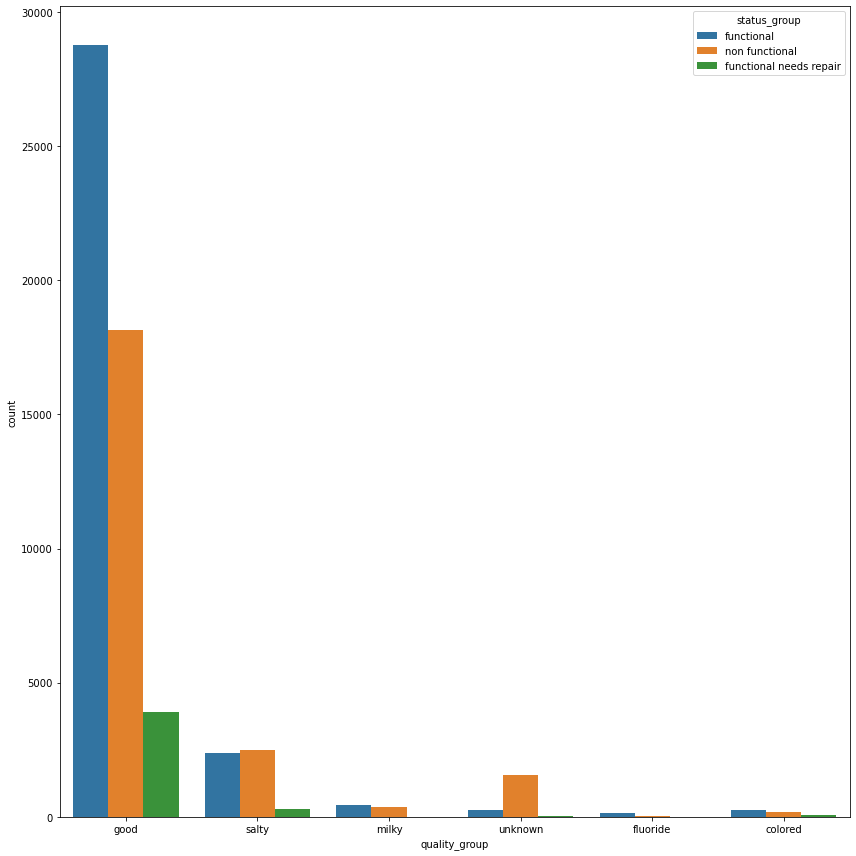

In [20]:
fig, ax = plt.subplots(figsize=(12,12))
sns.countplot(x='quality_group', hue='status_group', data=df)
plt.tight_layout()

The 'water_quality' and 'quality_group' columns provide redundant information. 'quality_group' is more desireable than 'quality_group' even though the latter is more specific because the latter's specificity does not add any meaninful information to our analysis.

Water of 'good' quality results in mostly functional wells, while those classified as an 'unknown' quality are mostly non-functional. They are unknown potentially due to the well being out of commission for such a long time that the water quality was no longer known by the time of recording.

AMOUNT_TSH -----------------------------------------------------------------------------------------------------------------------------------------------------------------

In [5]:
df.amount_tsh.value_counts().sum()

59400

In [6]:
df.amount_tsh.value_counts()

0.0         41639
500.0        3102
50.0         2472
1000.0       1488
20.0         1463
            ...  
8500.0          1
6300.0          1
220.0           1
138000.0        1
12.0            1
Name: amount_tsh, Length: 98, dtype: int64

In [7]:
print(f'Percentage of data that is zero: {41639/59400}')

Percentage of data that is zero: 0.700993265993266


The amount_tsh column describes the 'Total Static Head' of each well, which is defined as “The vertical height of a stationary column of liquid produced by a pump, measured from the suction level". This information could be useful for clasification, however 70% of all the values given are 0. We are unable to determine if the TSH level of these wells are actually zero, or if the number was simply used as a placeholder to describe a lack of information or a specific TSH status. Due to this, we will be dropping the column.

## Drop Columns and Deal with Missing Values

In [ ]:
df.isna().sum()[df.isna().sum()>0]

funder                3635
installer             3655
subvillage             371
public_meeting        3334
scheme_management     3877
scheme_name          28166
permit                3056
dtype: int64

In [2]:
# Label encode the target variable
status_labels = {'status_group':{'non functional': 0, 'functional': 1, 'functional needs repair': 2}}
df = df.replace(status_labels)
df.status_group.value_counts()


# Drop redundant and unneeded columns
to_drop = ['scheme_name', 'recorded_by', 'wpt_name', 'extraction_type', 'extraction_type_group',
           'region_code', 'district_code', 'lga', 'ward', 'public_meeting', 'date_recorded', 
           'source_type', 'source_class', 'waterpoint_type', 'water_quality', 'management_group', 
           'payment', 'quantity_group','subvillage', 'num_private', 'scheme_management', 'amount_tsh']


# Deal with missing values
df.drop(to_drop, axis=1, inplace=True)
df.permit.fillna(False, inplace=True)
df.dropna(axis=0, inplace=True)

# Set 'id' as the index of the dataframe
df.set_index('id', inplace=True)

## Grouping and Labeling Column Values

In [3]:
# Funder
df.funder.replace(to_replace='0', value='unknown', inplace=True)
df.funder.value_counts().head(20)

Government Of Tanzania    9080
Danida                    3114
Hesawa                    2197
Rwssp                     1373
World Bank                1338
Kkkt                      1287
World Vision              1239
Unicef                    1057
Tasaf                      876
District Council           842
Dhv                        829
Private Individual         826
Dwsp                       811
unknown                    777
Norad                      764
Germany Republi            610
Tcrs                       601
Ministry Of Water          586
Water                      583
Dwe                        484
Name: funder, dtype: int64

In [11]:
other = list(df.funder[df['funder'].map(df['funder'].value_counts()) < 484].values)
other
df['funder'].replace(other, 'other', inplace=True)

df.funder.replace(to_replace='0', value='Unknown', inplace=True)


In [12]:
# Installer

other = list(df.installer[df['installer'].map(df['installer'].value_counts()) < 392].values)
other
df['installer'].replace(other, 'other', inplace=True)

In [13]:
# Population

df['population'].replace(to_replace = 0 , value =df.population.mean(), inplace=True)
# Areas usually don't have zero population,so we are going to replace those values with the mean!

In [14]:
# Permit

df.permit.replace({True:1, False:0}, inplace=True)

In [15]:
# Population
    
def population(obs):
    s=''
    x=obs['population']
    if(0<x<=100):
        s='Less than 100'
    elif(100<x<=200):
        s='Between 100 and 200'
    elif(200<x<=300):
        s='Between 200 and 300'
    elif(300<x<=400):
        s='between 300 and 400'
    elif(400<x<=500):
        s='between 400 and 500'
    elif(500<x):
        s='Over 500'
    elif(x==0):
        s='No population'
    return s
df['population']=df.apply(population,axis=1)


In [16]:
# Construction year


conditions = [df['construction_year']==0, (df['construction_year']>=1960)&(df['construction_year']<=1970), (df['construction_year']>1970)&(df['construction_year']<=1980),
            (df['construction_year']>1980)&(df['construction_year']<=1990), (df['construction_year']>1990)&(df['construction_year']<=2000),
            (df['construction_year']>2000)&(df['construction_year']<=2010), df['construction_year']>2010]
choices = ['no_construction_year', '1960_1970', '1971_1980', '1981_1990', '1991_2000', '2001_2010', '2011_over']
df['construction_year'] = np.select(conditions, choices)


In [17]:
# # Amount_tsh
# # Bin
# conditions = [df.amount_tsh==0,(df.amount_tsh>0)&(df.amount_tsh<=10),(df.amount_tsh>10)&(df.amount_tsh<=100), (df.amount_tsh>100)&(df.amount_tsh<=1000),
#              (df.amount_tsh>1000)&(df.amount_tsh<=2000), (df.amount_tsh>2000)&(df.amount_tsh<=10000), (df.amount_tsh>10000)&(df.amount_tsh<=100000),
#              df.amount_tsh>100000]
# choices = ['zero', '1 to 10', '11 to 100', '101 to 1k', '1k to 2k', '2k to 10k', '10k to 100k', 'greater than 100k']
# df['amount_tsh'] = np.select(conditions, choices)

In [18]:
df.gps_height = pd.qcut(df.gps_height, 8, duplicates='drop', 
        labels=['-90m - sea level', 'sea level to 46m', '46m to 393m', '393m to 1017m', '1017m to 1316m', '1316m to 1586.75m', '1586.75m to 2770m'])

# More visualizations

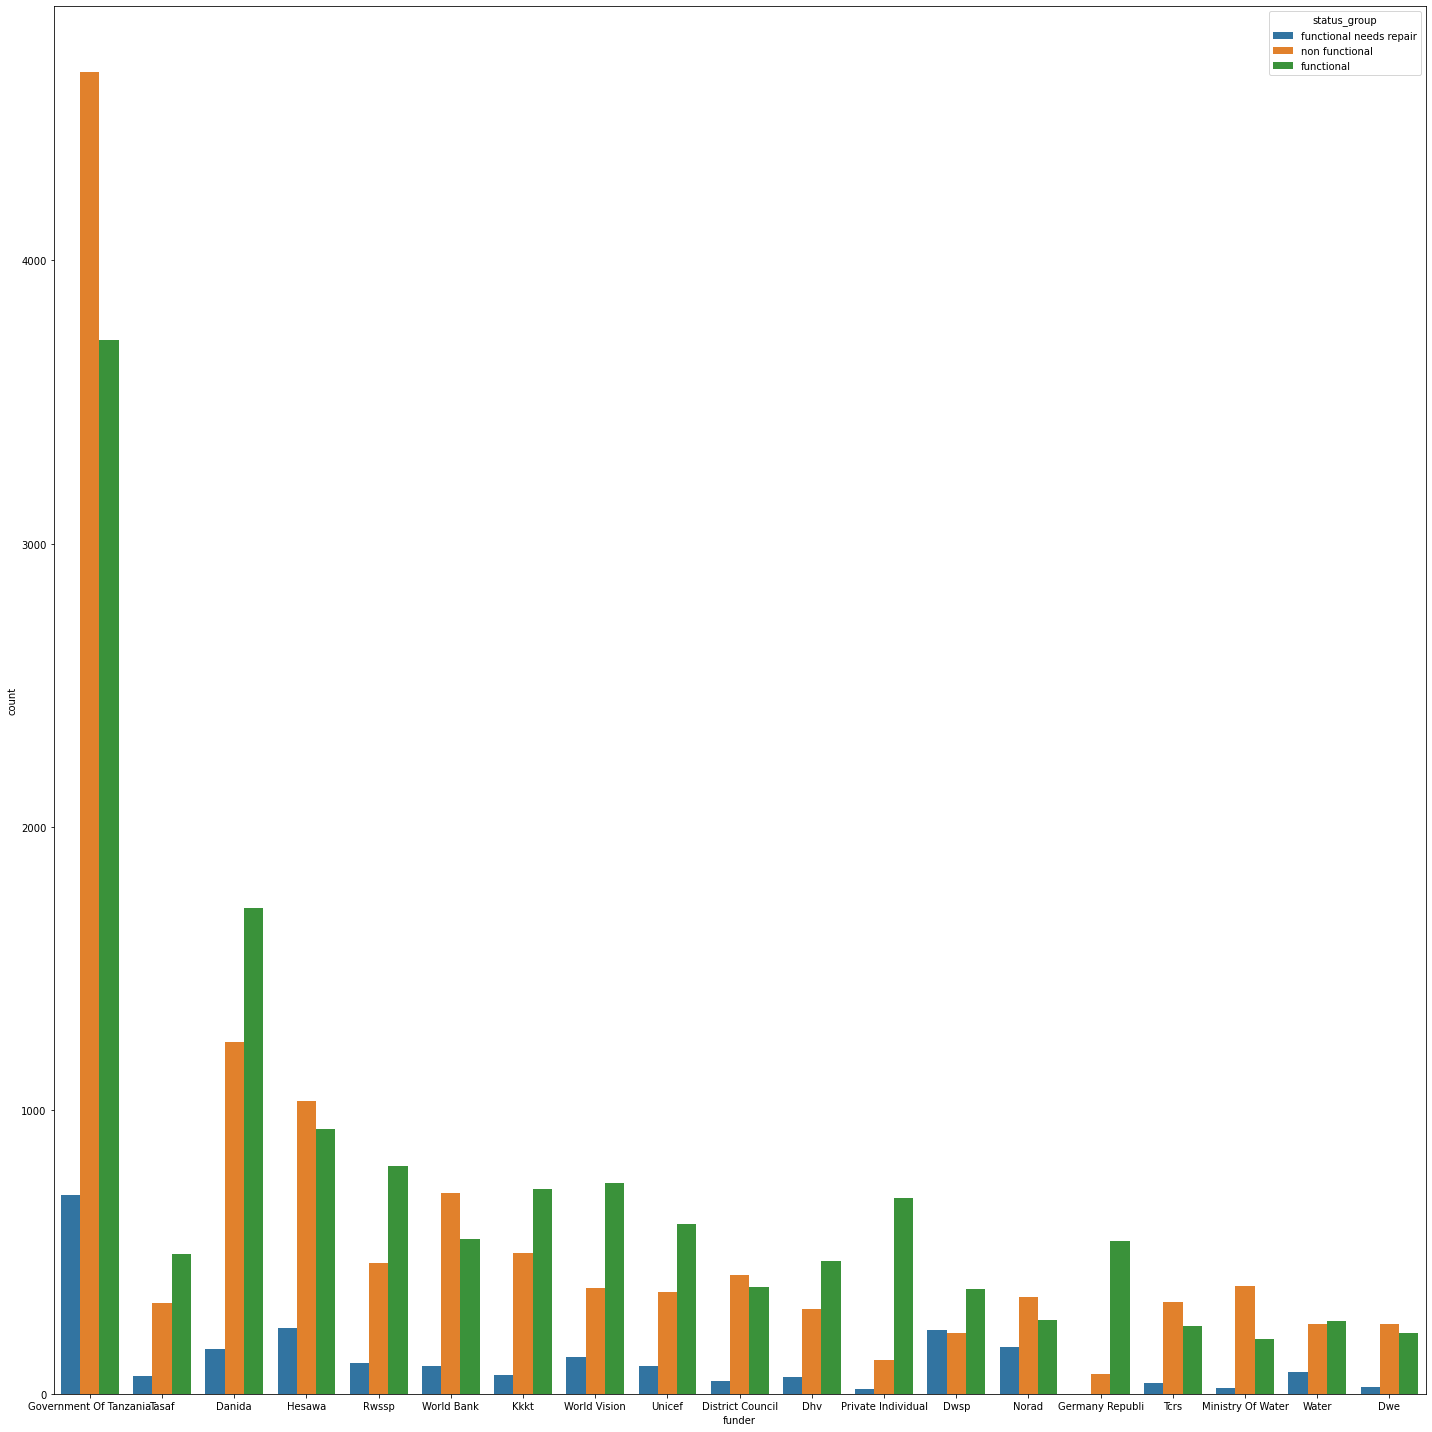

In [8]:
df1 = df.loc[df['funder']== 'Government Of Tanzania']
df2 = df.loc[df['funder']== 'Tasaf']              
df3 = df.loc[df['funder']== 'Danida'] 
df4 = df.loc[df['funder']== 'Hesawa'] 
df5 = df.loc[df['funder']== 'Rwssp'] 
df6 = df.loc[df['funder']== 'World Bank'] 
df7 = df.loc[df['funder']== 'Kkkt'] 
df8 = df.loc[df['funder']== 'World Vision']
df9 = df.loc[df['funder']== 'Unicef'] 
df10 = df.loc[df['funder']== 'unknown'] 
df11 = df.loc[df['funder']== 'District Council'] 
df12 = df.loc[df['funder']== 'Dhv'] 
df13 = df.loc[df['funder']== 'Private Individual'] 
df14 = df.loc[df['funder']== 'Dwsp'] 
df15 = df.loc[df['funder']== 'Norad'] 
df16 = df.loc[df['funder']== 'Germany Republi']
df17 = df.loc[df['funder']== 'Tcrs']
df18 = df.loc[df['funder']== 'Ministry Of Water']
df19 = df.loc[df['funder']== 'Water']
df20 = df.loc[df['funder']== 'Dwe']

top_20 = pd.concat([df1,df2,df3,df4,df5,df6,df7,df8,df9,df10,df11,df12,
                    df13,df14,df15,df16,df17,df18,df19,df20], ignore_index=True)

fig, ax = plt.subplots(figsize=(20,20))
sns.countplot(x='funder', hue="status_group", data=top_20)
plt.tight_layout()

Who funded the well has a considerable effect on the functionality of it. The Government of Tanzania, Hesawa, World Bank, Tcrs, Ministry of Water (ironically), and DWE have funded a majority of wells that were non-functional at the time this data was recorded. Overall, it seems as if private individuals and the Germany Republic funded wells that had the highest ratio of functional to non-functional at the time this data was recorded.

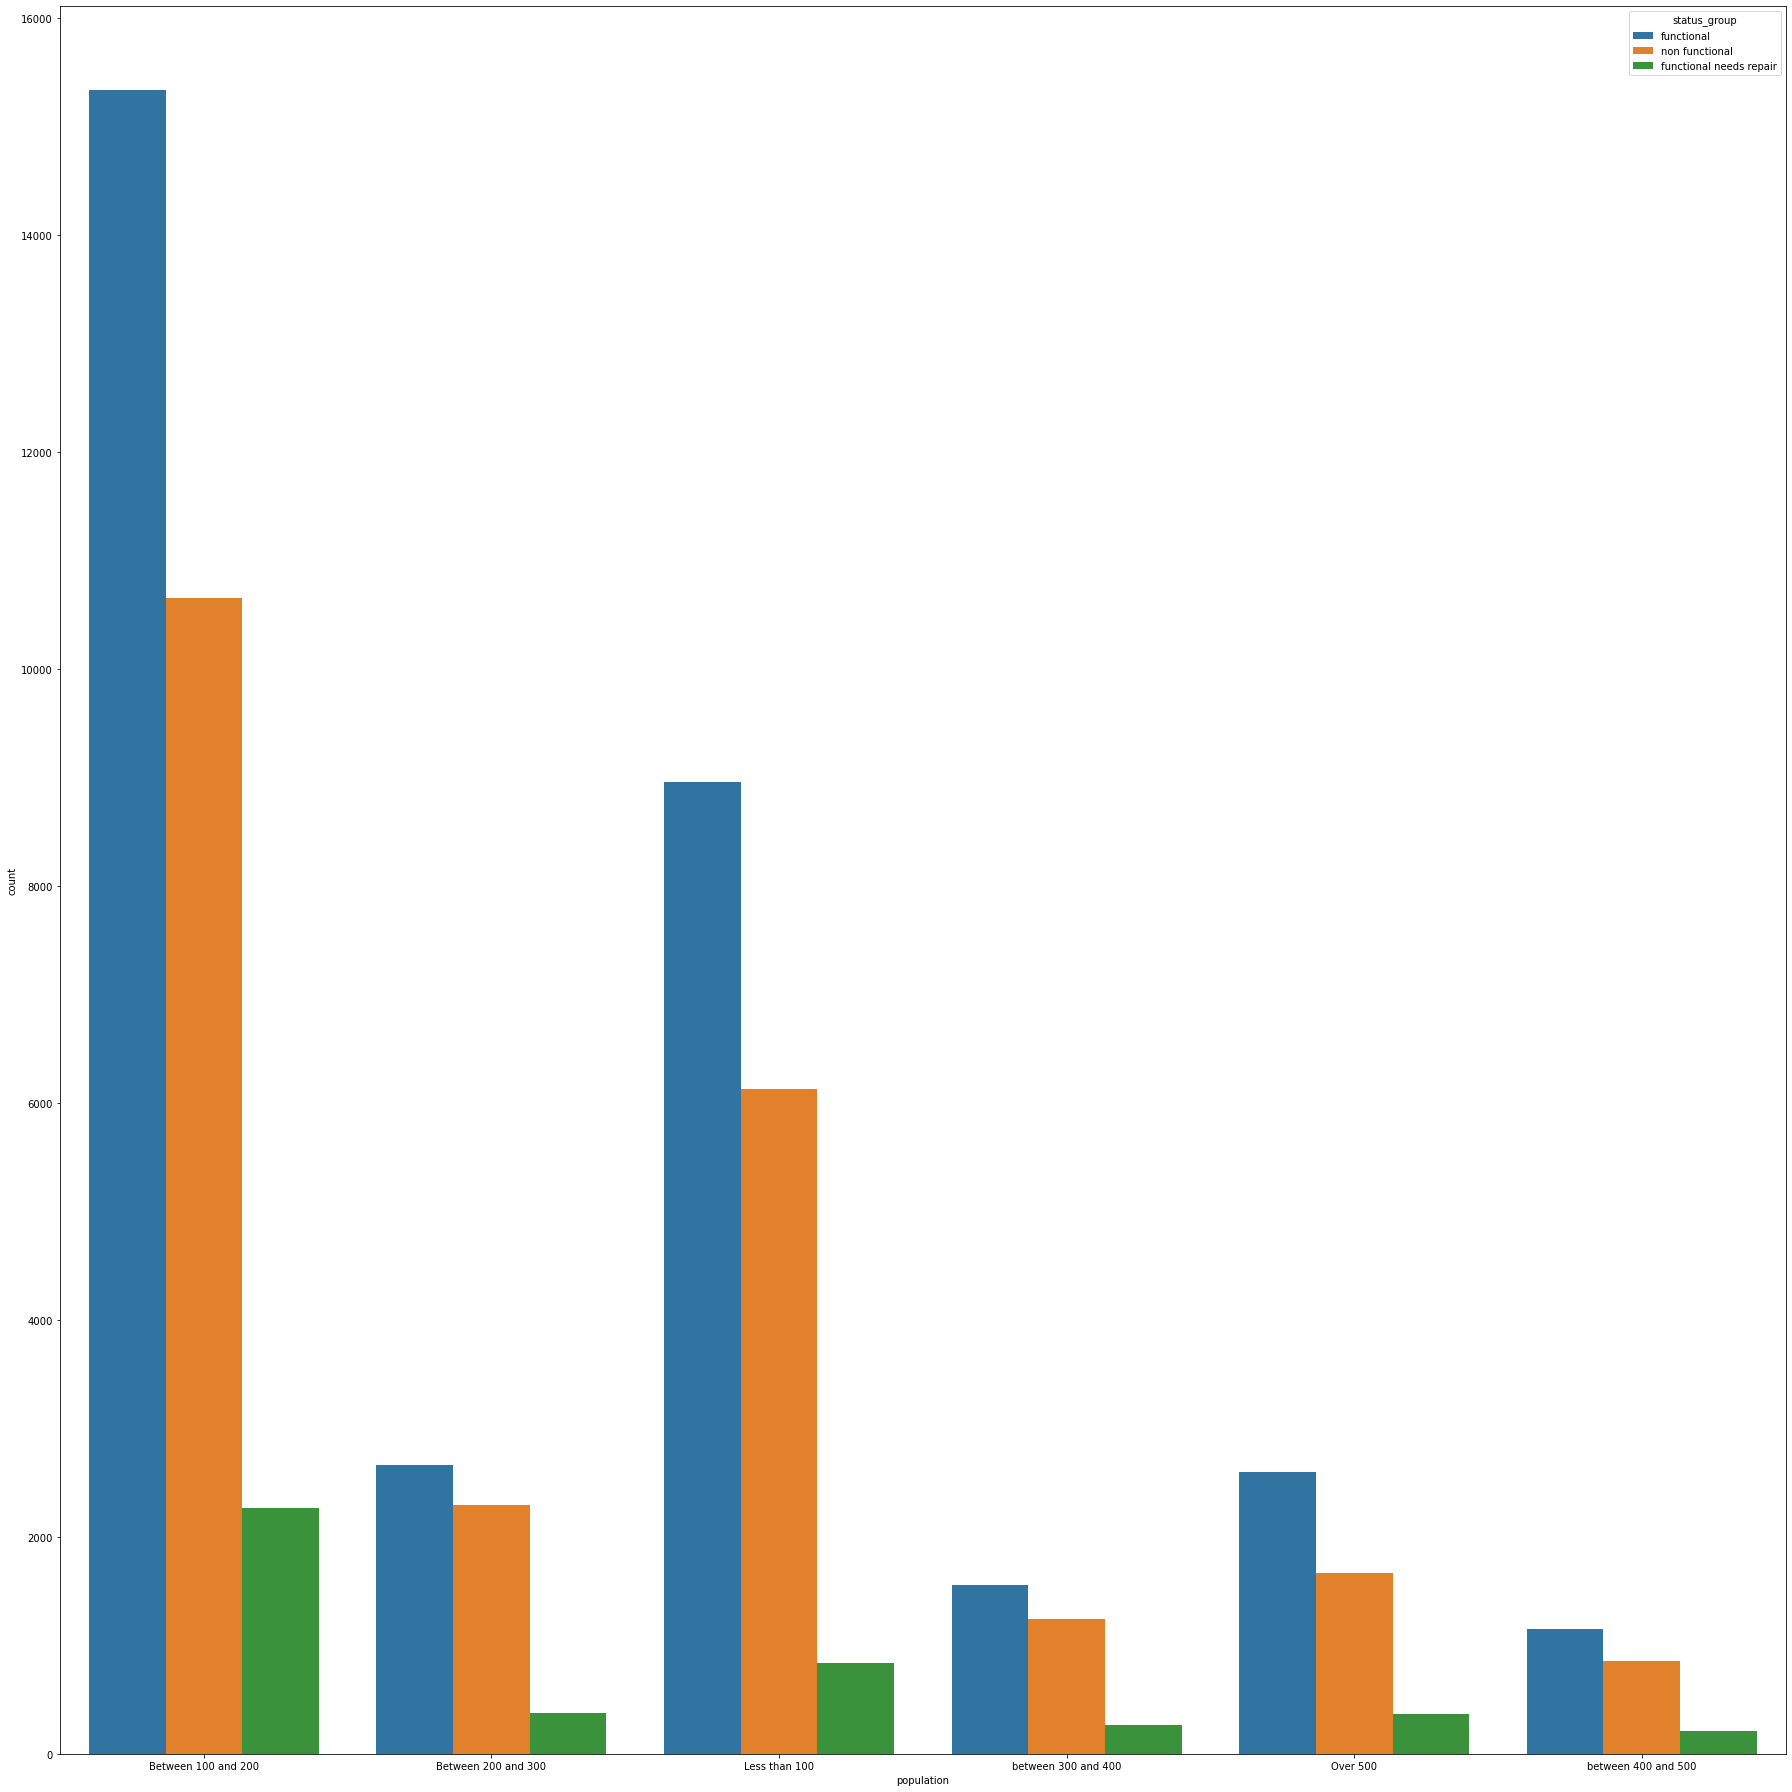

In [20]:
fig, ax = plt.subplots(figsize=(25,25))
sns.countplot(x='population', hue='status_group', data=df)
plt.tight_layout()

The lower the population, the more wells are present, most likely due to the fact that Tanzania is still composed of villages and hamlets with low urbanization. The less people around a well, the higher the likelihood of the well being functional. This could be attributed to the possibility that overuse results in non-functionality. 

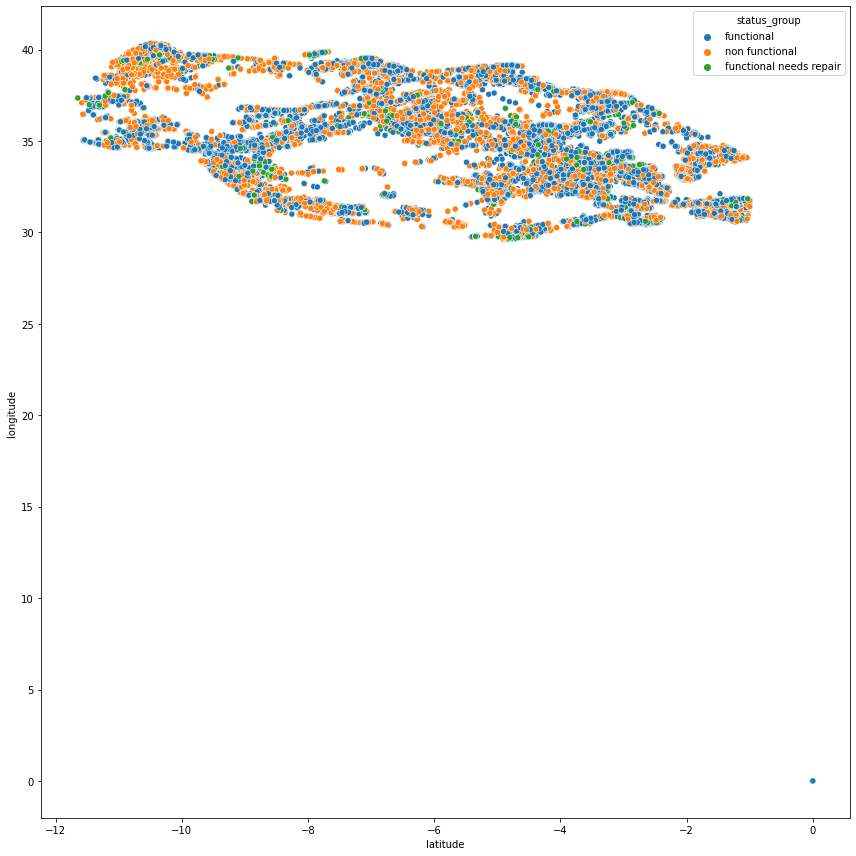

In [19]:
fig, ax = plt.subplots(figsize=(12,12))
sns.scatterplot(x='latitude', y='longitude', hue='status_group',data=df)
plt.tight_layout()

Latitude and longitude data is displayed above. There are certain areas that seem to have more functional or non-functional wells. This could provide useful classification for our model based on specific location.

NEED TO USE GEOPANDAS TO UNDERSTAND THIS BETTER

# Model Building

In [ ]:
df.status_group.value_counts().plot(kind='bar', color='orange')

There is a clear class imbalance for our target variable. We will have to deal with this during our modeling.


Potential methods:
- SMOTE
- Undersampling
- Ensemble methods
- Cost-sensitive algorithms

## Import Libraries/Modules, Define Variables, OneHotEncode

In [14]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler, RobustScaler
from sklearn.impute import MissingIndicator, SimpleImputer
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, GridSearchCV
from sklearn.feature_selection import SelectFromModel
from xgboost import XGBClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.feature_selection import RFE
from imblearn.pipeline import make_pipeline
from imblearn.over_sampling import SMOTE


# plot_confusion_matrix is a handy visual tool, added in the latest version of scikit-learn
# if you are running an older version, comment out this line and just use confusion_matrix

from sklearn.metrics import plot_confusion_matrix, f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import make_scorer

In [15]:
# Identify features and target
features = df.drop('status_group', axis=1)
target = df.status_group

# Dummy the features
features_dummied = pd.get_dummies(features, drop_first=True)
features_dummied.head()

# OneHotEncode the features
encoder = OneHotEncoder()
features_ohe = encoder.fit_transform(features)
df_ohe = encoder.fit_transform(df)

## Decision Tree

In [ ]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(features_ohe, target, test_size=0.2, random_state=123)

In [ ]:
# Build model
tree = DecisionTreeClassifier(random_state=123)

# Train model
tree.fit(X_train, y_train)

# Score model
tree.score(X_test, y_test)

## Random Forest

In [ ]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(features_ohe, target, test_size=0.2, random_state=123)

In [ ]:
# Build model
forest = RandomForestClassifier(random_state=123)

# Train model
forest.fit(X_train, y_train)

# Score model
forest.score(X_test, y_test)

## Naive Bayes

In [ ]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(features_ohe, target, test_size=0.2, random_state=123)

In [ ]:
# Build model
nb = MultinomialNB()

# Train model
nb.fit(X_train, y_train)

# Score model
nb.score(X_test, y_test)

## XGBoost

In [28]:
num_col = list(df[['longitude', 'latitude']].columns)
cat_col = list(df.drop(['longitude', 'latitude', 'status_group'], axis=1).columns)
import category_encoders as ce
from sklearn.compose import ColumnTransformer
# cat_col_ohe = encoder.fit_transform(cat_col)
# cat_col_ohe_df = pd.DataFrame(cat_col)
# df_model = df
# scaler = RobustScaler()
# df[num_col]=scaler.fit_transform(df[num_col])
# df[cat_col]=encoder.fit_transform(df[cat_col])

# choosing scaler and encoder
scaler=RobustScaler()
encoder = ce.TargetEncoder(cols=cat_col)

# putting numeric columns to scaler and categorical to encoder
num_transformer = make_pipeline(scaler)
cat_transformer = make_pipeline(encoder)

# getting together our scaler and encoder with preprocessor
preprocessor = ColumnTransformer(
      transformers=[('num', num_transformer, num_col),
                    ('cat', cat_transformer, cat_col)])

In [32]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(features_ohe, target, test_size=0.2, random_state=123)

In [33]:
# # Build model
X_resampled, y_resampled = SMOTE(sampling_strategy='minority', random_state = 123).fit_sample(X_train, y_train)
xg = XGBClassifier(random_state=123, objective = 'multi:softmax', num_class=3, verbosity=1, n_jobs=-1)

# # # Train model
# xg.fit(X_resampled, y_resampled)

# # # Score model
# y_preds = xg.predict(X_test)



ValueError: Specifying the columns using strings is only supported for pandas DataFrames

In [19]:
# # # Train model
xg.fit(X_resampled, y_resampled)

# # # Score model
xg.score(X_test, y_test)

0.755633360265733

In [ ]:
parameters = {
    'max_depth': [12, 16, 24] ,
    'n_estimators': [160, 220, 250],
    'learning_rate': [0.12, 0.001, 0.01, 0.05]}

In [ ]:
grid_search = GridSearchCV(
    estimator=xg,
    param_grid=parameters,
    n_jobs = 10,
    cv = 5,
    verbose=True
)

In [ ]:
grid_search.fit(X_train, y_train)

In [ ]:
grid_search.best_params_

I did not get a good score the first time around.
0.78814

## Support Vector

In [ ]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(features_ohe, target, test_size=0.2, random_state=123)

# Recursive feature elimination
rfe = RFE(SVC(), n_features_to_select = 20)
rfe = rfe.fit(X_train, y_train)
rfe_columns = pd.Series(X_train.columns)
rfe_code = pd.Series(rfe.support_)
columns_to_keep = pd.concat([rfe_columns, rfe_code], axis=1)
rfe_X_train = X_train[list(columns_to_keep[columns_to_keep[1]==True][0])]
rfe_X_test = X_test[list(columns_to_keep[columns_to_keep[1]==True][0])]

In [ ]:
# Build model
svc = SVC(random_state=123, gamma='auto')

# Train model
svc.fit(X_train, y_train)

# Score model
svc.score(X_test, y_test)